# General Functions to use

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import numpy as np
from keras.engine.topology import Layer, InputSpec
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import mean_absolute_error, r2_score
import keras.models as models
from sklearn import linear_model
import keras.backend as K
from keras.layers import Merge
import keras.layers as layers
from keras.layers.core import Lambda
from sklearn.metrics import mean_squared_error
from keras.layers.advanced_activations import LeakyReLU, PReLU, ThresholdedReLU, ELU
import tensorflow as tf
np.random.seed(101)

ModuleNotFoundError: No module named 'numpy'

In [22]:
def create_timestepped_data(data_frame, time_steps):
    d = []
    for i in range(time_steps):
        # chopping off the NaN's at the bottom because of shift(-i)
        # right most row will contain the latest day's sale
        d.append(data_frame.shift(-i).values[:-time_steps])
        
    # changing the dimensions from (timeSteps,dataPts,fts) to (dataPts,timeSteps,fts) 
    return np.transpose(np.array(d),(1,0,2))

In [23]:
def create_formatted_data(df, time_steps, num_features):
    assert (time_steps%2 !=0), "Time steps should be odd!"
    d = create_time_stepped_data(df, time_steps, num_features)
    
    past = d[:,:int(time_steps/2),:]
    fut = np.flip(d[:,int(time_steps/2)+1:,:],1)
    y = d[:,int(time_steps/2),-1]
    if(num_features == 0):
        cur = np.zeros((d.shape[0],1,256))
    else:
        cur = d[:,int(time_steps/2),:-1]
        cur = np.dstack((cur.reshape(-1,1,num_features+1),np.zeros(shape=(d.shape[0],1,256-num_features))))
    return past,cur,fut,y

In [4]:
def train_test_split(past,fut,cur,y):
    train_split = int(0.7*y.shape[0])
    return past[:train_split], past[train_split:], fut[:train_split], np.zeros_like(past[train_split:]), cur[:train_split], cur[train_split:], y[:train_split], y[train_split:]    

In [200]:
def model_build(input_shape1, input_shape2, cur_input_shape, multiplier1 = 2.0,multiplier2 = 0.0):
    
    past_inp = layers.Input(shape=(input_shape1))
    fut_inp = layers.Input(shape=(input_shape2))
    cur_inp = layers.Input(shape=(cur_input_shape))
    
    cnn1 = layers.Conv1D(filters=256,kernel_size=5)(past_inp)
    #cnn1 = layers.MaxPool1D(pool_size=2)(cnn1)
    cnn1 = layers.Conv1D(filters=256,kernel_size=2)(cnn1)
    cnn1 = layers.Dense(256)(cnn1)
    cnn1 = layers.advanced_activations.LeakyReLU(0.2)(cnn1)
    
    cnn2 = layers.Conv1D(filters=256,kernel_size=5)(fut_inp)
    #cnn2 = layers.MaxPool1D(pool_size=2)(cnn2)
    cnn2 = layers.Conv1D(filters=256,kernel_size=2)(cnn2)
    cnn2 = layers.Dense(256)(cnn2)
    cnn2 = layers.advanced_activations.LeakyReLU(0.2)(cnn2)
    
    cnn1_1 = Lambda(lambda x: tf.multiply(x,multiplier1))(cnn1)
    cnn2_2 = Lambda(lambda x: x * multiplier2)(cnn2)
    
    cnn_out = layers.Concatenate(axis=1)([cnn1_1,cnn2_2])
    
    lstm_inp = layers.Add()([cnn_out,cur_inp])
    
    x1 = layers.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(lstm_inp)
    x1 = layers.Dense(516)(x1)
    x1 = layers.Dropout(0.2)(x1)
    x1 = layers.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(x1)
    x1 = layers.Dense(516)(x1)
    x1 = layers.Dropout(0.2)(x1)
    x1 = layers.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(x1)
    x1 = layers.Dense(256)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    lstm_out = layers.Dropout(0.2)(x1)
    
    x1 = layers.Concatenate(axis=1)([lstm_out,cnn_out])
    x1 = layers.Flatten()(x1)
    
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1)(x1)
    main_out = layers.advanced_activations.LeakyReLU(0.2)(x1)
    
    model = models.Model(inputs=[past_inp,fut_inp,cur_inp], outputs=[main_out], name='CLDNN')
    model.summary()
    model.compile(optimizer='adam',loss=tf.losses.huber_loss,metrics=['mae'])
    
    return model
    
    

In [5]:
def model_build1(input_shape1, multiplier1 = 2.0, multiplier2 = 0.0):
    
    past_inp = layers.Input(shape=(input_shape1))
    
    cnn1 = layers.Conv1D(filters=256,kernel_size=5)(past_inp)
    #cnn1 = layers.MaxPool1D(pool_size=2)(cnn1)
    cnn1 = layers.Conv1D(filters=256,kernel_size=2)(cnn1)
    cnn1 = layers.Dense(256)(cnn1)
    cnn1 = layers.advanced_activations.LeakyReLU(0.2)(cnn1)
    
    cnn1_1 = Lambda(lambda x: tf.multiply(x,multiplier1))(cnn1)
        
    x1 = layers.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(cnn1_1)
    x1 = layers.Dense(516)(x1)
    x1 = layers.Dropout(0.2)(x1)
    x1 = layers.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(x1)
    x1 = layers.Dense(516)(x1)
    x1 = layers.Dropout(0.2)(x1)
    x1 = layers.LSTM(832, unroll=True, recurrent_dropout=0.3, return_sequences=True)(x1)
    x1 = layers.Dense(256)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    lstm_out = layers.Dropout(0.2)(x1)
    
    x1 = layers.Concatenate(axis=1)([lstm_out,cnn1_1])
    x1 = layers.Flatten()(x1)
    
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1)(x1)
    main_out = layers.advanced_activations.LeakyReLU(0.2)(x1)
    
    model = models.Model(inputs=[past_inp], outputs=[main_out], name='CLDNN')
    model.summary()
    model.compile(optimizer='adam',loss=tf.losses.huber_loss,metrics=['mae'])
    
    return model    

# Monthly Car sales

In [11]:
df = pd.read_csv("monthly-car-sales-in-quebec-1960.csv")["Monthly car sales in Quebec 1960-1968"][:-1]

In [ ]:
df = np.log(df)-np.log(df.shift())
df = df.dropna()

In [ ]:
df = savgol_filter(df,5,3)

In [13]:
time_steps = 21
num_features = 5
data = pd.DataFrame(df)
data_norm = pd.DataFrame(df)
#data_norm = (data - data.min())/(2**np.ceil(np.log2(data.max())) - data.min())
d = create_timestepped_data(pd.DataFrame(data_norm),time_steps)
past = d[:,:int(time_steps/2),:]
fut = np.flip(d[:,int(time_steps/2)+1:,:],1)
cur = d[:,int(time_steps/2),:]
cur = np.dstack((cur.reshape(-1,1,1),np.zeros(shape=(cur.shape[0],1,255))))
y = d[:,int(time_steps/2),]# * (2**np.ceil(np.log2(data.max()))[-1] - data.min()[-1]) + data.min()[-1]
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)

In [8]:
model1 = model_build(past.shape[1:], fut.shape[1:], cur.shape[1:])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 6, 256)       1536        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 6, 256)       1536        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (

In [9]:
model1.fit(x=[past_train,fut_train,cur_train], y=y_train, epochs=100, batch_size=32,
          validation_data=([past_test,fut_test,cur_test],y_test))

Train on 60 samples, validate on 27 samples
Epoch 1/100
60/60 [==============================] - 6s 105ms/step - loss: 134209724.0000 - mean_absolute_error: 10050.7765 - val_loss: 289276256.0000 - val_mean_absolute_error: 16650.1543
Epoch 2/100
60/60 [==============================] - 1s 16ms/step - loss: 140201862.9333 - mean_absolute_error: 10564.4690 - val_loss: 1005249344.0000 - val_mean_absolute_error: 31144.7773
Epoch 3/100
60/60 [==============================] - 1s 16ms/step - loss: 1877615012.8000 - mean_absolute_error: 34787.4050 - val_loss: 287796064.0000 - val_mean_absolute_error: 16605.9961
Epoch 4/100
60/60 [==============================] - 1s 16ms/step - loss: 206166373.3333 - mean_absolute_error: 13692.4483 - val_loss: 245174816.0000 - val_mean_absolute_error: 15256.6885
Epoch 5/100
60/60 [==============================] - 1s 16ms/step - loss: 101246354.4000 - mean_absolute_error: 8284.1868 - val_loss: 18745514.0000 - val_mean_absolute_error: 3959.2349
Epoch 6/100
60/6

Epoch 45/100
60/60 [==============================] - 1s 16ms/step - loss: 2693833.7500 - mean_absolute_error: 1297.2494 - val_loss: 44996020.0000 - val_mean_absolute_error: 5841.1411
Epoch 46/100
60/60 [==============================] - 1s 16ms/step - loss: 2998834.7500 - mean_absolute_error: 1428.4084 - val_loss: 67476240.0000 - val_mean_absolute_error: 7544.2690
Epoch 47/100
60/60 [==============================] - 1s 16ms/step - loss: 3091376.1167 - mean_absolute_error: 1388.6599 - val_loss: 47302688.0000 - val_mean_absolute_error: 6053.1221
Epoch 48/100
60/60 [==============================] - 1s 16ms/step - loss: 2195002.1500 - mean_absolute_error: 1204.0356 - val_loss: 53799264.0000 - val_mean_absolute_error: 6574.3335
Epoch 49/100
60/60 [==============================] - 1s 16ms/step - loss: 2218323.1000 - mean_absolute_error: 1174.1558 - val_loss: 48877036.0000 - val_mean_absolute_error: 6191.7129
Epoch 50/100
60/60 [==============================] - 1s 16ms/step - loss: 18977

Epoch 90/100
60/60 [==============================] - 1s 16ms/step - loss: 2048106.5000 - mean_absolute_error: 1141.9605 - val_loss: 66225812.0000 - val_mean_absolute_error: 7541.4937
Epoch 91/100
60/60 [==============================] - 1s 16ms/step - loss: 1384621.1167 - mean_absolute_error: 964.9607 - val_loss: 68431448.0000 - val_mean_absolute_error: 7684.7183
Epoch 92/100
60/60 [==============================] - 1s 16ms/step - loss: 1367991.4500 - mean_absolute_error: 906.7020 - val_loss: 64291640.0000 - val_mean_absolute_error: 7409.9414
Epoch 93/100
60/60 [==============================] - 1s 16ms/step - loss: 1275427.6417 - mean_absolute_error: 922.5006 - val_loss: 79508112.0000 - val_mean_absolute_error: 8382.1270
Epoch 94/100
60/60 [==============================] - 1s 16ms/step - loss: 1302084.2708 - mean_absolute_error: 904.3568 - val_loss: 63983608.0000 - val_mean_absolute_error: 7397.4570
Epoch 95/100
60/60 [==============================] - 1s 16ms/step - loss: 976207.19

In [10]:
y_pred1 = model1.predict([past_test, fut_test, cur_test], batch_size=32)
y_pred2 = model1.predict([past, fut, cur], batch_size=32)
pred1 = pd.Series(np.array(y_pred1).reshape((-1,)))
test1 = pd.Series(y_test.reshape((-1,)))
pred2 = pd.Series(np.array(y_pred2).reshape((-1,)))
test2 = pd.Series(y.reshape((-1,)))
print(pred1.shape, test1.shape, pred2.shape, test2.shape)

(27,) (27,) (87,) (87,)


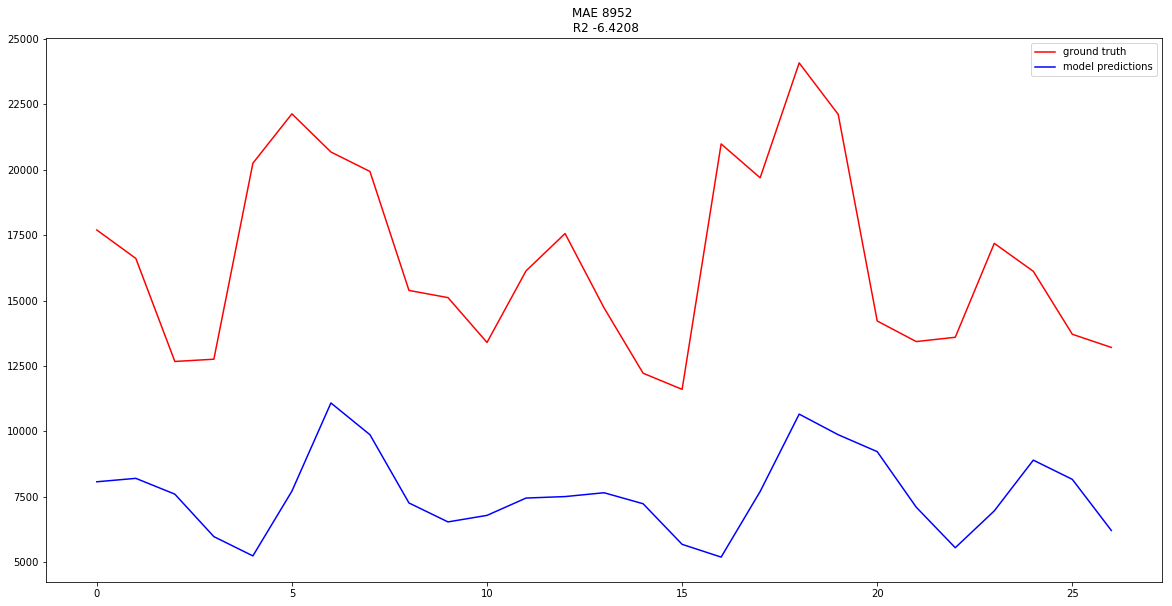

In [11]:
# Just for fun did for entire data
plt.figure(figsize=(20,10))
const = 0
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test1,pred1), r2_score(test1,pred1)))
plt.plot(test1, color='r', label='ground truth')
plt.plot(pred1, color='b', label='model predictions')
# plt.bar(left=np.array(test.index)-0.2, height=test, width=0.4, color='r', label='ground truth')
# plt.bar(left=np.array(test.index)+0.2, height=pred, width=0.4,  color='b', label='model predictions')
plt.legend()
plt.show()

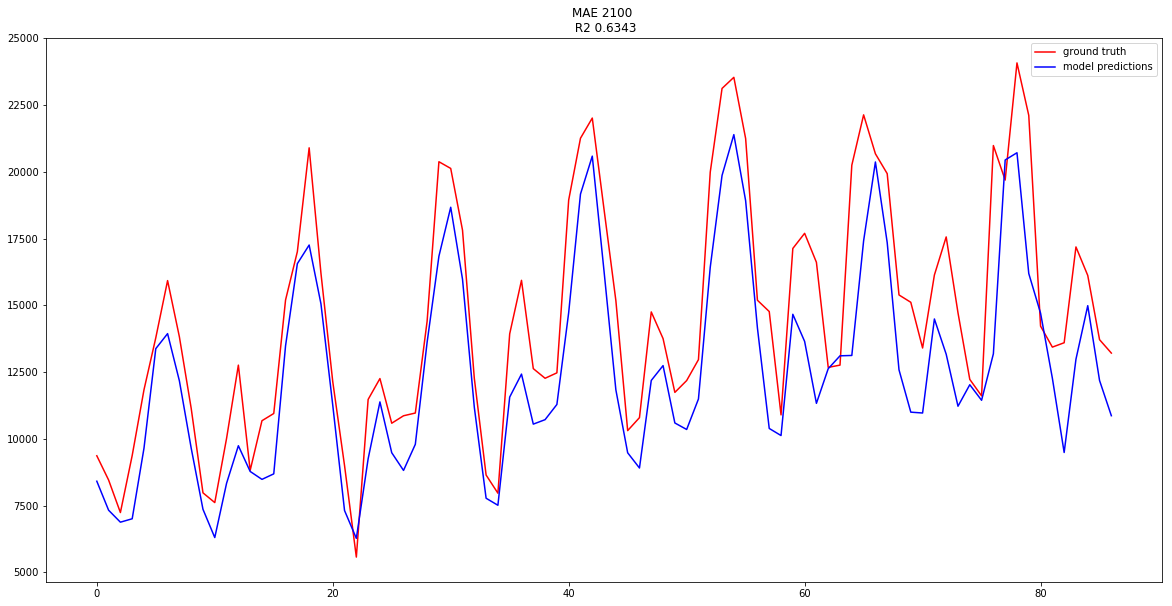

In [12]:
# Just for fun did for entire data
plt.figure(figsize=(20,10))
const = 0
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test2,pred2), r2_score(test2,pred2)))
plt.plot(test2, color='r', label='ground truth')
plt.plot(pred2, color='b', label='model predictions')
# plt.bar(left=np.array(test.index)-0.2, height=test, width=0.4, color='r', label='ground truth')
# plt.bar(left=np.array(test.index)+0.2, height=pred, width=0.4,  color='b', label='model predictions')
plt.legend()
plt.show()

# Wolfer yearly Sunspot

In [5]:
df = pd.DataFrame(pd.read_csv("wolfer-sunspot-numbers-1770-to-1.csv")['Wolfer sunspot numbers, 1770 to 1869'][:-1])

In [11]:
time_steps = 21
num_features = 5

In [10]:
data = pd.DataFrame(df)
data_norm = pd.DataFrame(df)
#data_norm = (data - data.min())/(2**np.ceil(np.log2(data.max())) - data.min())

In [30]:
d = create_timestepped_data(data_norm,time_steps)
past = d[:,:int(time_steps/2),:]
fut = np.flip(d[:,int(time_steps/2)+1:,:],1)
cur = d[:,int(time_steps/2),:]

In [ ]:



cur = np.dstack((cur.reshape(-1,1,1),np.zeros(shape=(cur.shape[0],1,255))))
y = d[:,int(time_steps/2),]# * (2**np.ceil(np.log2(data.max()))[-1] - data.min()[-1]) + data.min()[-1]
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)

In [ ]:
model1 = model_build(past.shape[1:], fut.shape[1:], cur.shape[1:])

In [ ]:
model1.fit(x=[past_train,fut_train,cur_train], y=y_train, epochs=100, batch_size=32,
          validation_data=([past_test,fut_test,cur_test],y_test))

In [ ]:
y_pred1 = model1.predict([past_test, fut_test, cur_test], batch_size=32)
y_pred2 = model1.predict([past, fut, cur], batch_size=32)
pred1 = pd.Series(np.array(y_pred1).reshape((-1,)))
test1 = pd.Series(y_test.reshape((-1,)))
pred2 = pd.Series(np.array(y_pred2).reshape((-1,)))
test2 = pd.Series(y.reshape((-1,)))
print(pred1.shape, test1.shape, pred2.shape, test2.shape)

In [ ]:
# Just for fun did for entire data
plt.figure(figsize=(20,10))
const = 0
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test1,pred1), r2_score(test1,pred1)))
plt.plot(test1, color='r', label='ground truth')
plt.plot(pred1, color='b', label='model predictions')
# plt.bar(left=np.array(test.index)-0.2, height=test, width=0.4, color='r', label='ground truth')
# plt.bar(left=np.array(test.index)+0.2, height=pred, width=0.4,  color='b', label='model predictions')
plt.legend()
plt.show()

In [ ]:
# Just for fun did for entire data
plt.figure(figsize=(20,10))
const = 0
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test2,pred2), r2_score(test2,pred2)))
plt.plot(test2, color='r', label='ground truth')
plt.plot(pred2, color='b', label='model predictions')
# plt.bar(left=np.array(test.index)-0.2, height=test, width=0.4, color='r', label='ground truth')
# plt.bar(left=np.array(test.index)+0.2, height=pred, width=0.4,  color='b', label='model predictions')
plt.legend()
plt.show()

# Airpassengers Data 

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
(122, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_13 (Co

Train on 100 samples, validate on 22 samples
Epoch 1/100
100/100 [==============================] - 9s 93ms/step - loss: 0.0306 - mean_absolute_error: 0.1571 - val_loss: 0.0105 - val_mean_absolute_error: 0.0862
Epoch 2/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0081 - mean_absolute_error: 0.0710 - val_loss: 0.0052 - val_mean_absolute_error: 0.0592
Epoch 3/100
100/100 [==============================] - 2s 17ms/step - loss: 0.0046 - mean_absolute_error: 0.0563 - val_loss: 0.0042 - val_mean_absolute_error: 0.0564
Epoch 4/100
100/100 [==============================] - 2s 17ms/step - loss: 0.0039 - mean_absolute_error: 0.0541 - val_loss: 0.0015 - val_mean_absolute_error: 0.0307
Epoch 5/100
100/100 [==============================] - 2s 17ms/step - loss: 0.0012 - mean_absolute_error: 0.0286 - val_loss: 7.8620e-04 - val_mean_absolute_error: 0.0229
Epoch 6/100
100/100 [==============================] - 2s 17ms/step - loss: 7.3348e-04 - mean_absolute_error: 0.0210 - va

Epoch 48/100
100/100 [==============================] - 2s 17ms/step - loss: 3.2475e-05 - mean_absolute_error: 0.0047 - val_loss: 3.5138e-05 - val_mean_absolute_error: 0.0045
Epoch 49/100
100/100 [==============================] - 2s 17ms/step - loss: 2.0953e-05 - mean_absolute_error: 0.0036 - val_loss: 4.0563e-05 - val_mean_absolute_error: 0.0055
Epoch 50/100
100/100 [==============================] - 2s 17ms/step - loss: 1.8184e-05 - mean_absolute_error: 0.0033 - val_loss: 3.6880e-05 - val_mean_absolute_error: 0.0046
Epoch 51/100
100/100 [==============================] - 2s 17ms/step - loss: 2.5156e-05 - mean_absolute_error: 0.0040 - val_loss: 6.5471e-05 - val_mean_absolute_error: 0.0058
Epoch 52/100
100/100 [==============================] - 2s 17ms/step - loss: 2.7639e-05 - mean_absolute_error: 0.0042 - val_loss: 3.8151e-05 - val_mean_absolute_error: 0.0049
Epoch 53/100
100/100 [==============================] - 2s 17ms/step - loss: 2.4951e-05 - mean_absolute_error: 0.0041 - val_l

Epoch 95/100
100/100 [==============================] - 2s 18ms/step - loss: 3.7006e-05 - mean_absolute_error: 0.0049 - val_loss: 7.3308e-05 - val_mean_absolute_error: 0.0067
Epoch 96/100
100/100 [==============================] - 2s 17ms/step - loss: 5.0968e-05 - mean_absolute_error: 0.0059 - val_loss: 7.4826e-05 - val_mean_absolute_error: 0.0078
Epoch 97/100
100/100 [==============================] - 2s 17ms/step - loss: 7.9966e-05 - mean_absolute_error: 0.0074 - val_loss: 6.4978e-05 - val_mean_absolute_error: 0.0056
Epoch 98/100
100/100 [==============================] - 2s 17ms/step - loss: 5.9810e-05 - mean_absolute_error: 0.0069 - val_loss: 6.8442e-05 - val_mean_absolute_error: 0.0065
Epoch 99/100
100/100 [==============================] - 2s 17ms/step - loss: 3.7047e-05 - mean_absolute_error: 0.0049 - val_loss: 4.0427e-05 - val_mean_absolute_error: 0.0042
Epoch 100/100
100/100 [==============================] - 2s 17ms/step - loss: 2.6698e-05 - mean_absolute_error: 0.0042 - val_

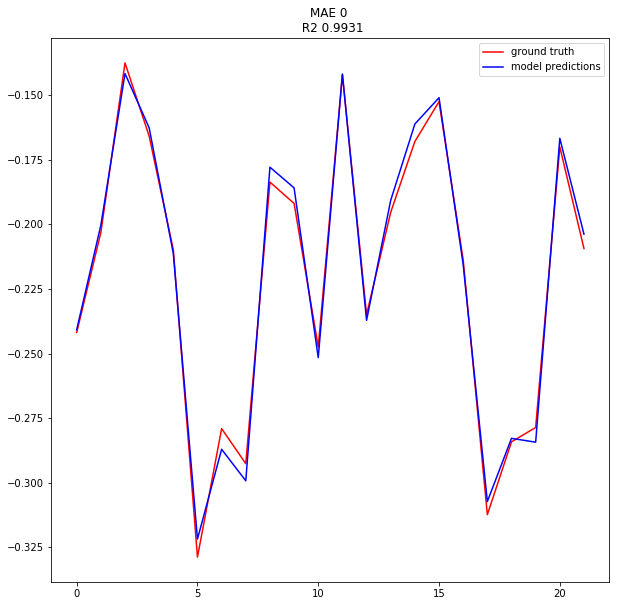

In [16]:
data = pd.read_csv('AirPassengers.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print(data.head())

data.index

ts = data['#Passengers'] 
ts.head(10)

#1. Specific the index as a string constant:
ts['1949-01-01']

#2. Import the datetime library and use 'datetime' function:
from datetime import datetime
ts[datetime(1949,1,1)]

#1. Specify the entire range:
ts['1949-01-01':'1949-05-01']

#2. Use ':' if one of the indices is at ends:
ts[:'1949-05-01']

ts['1949']
# plt.plot(ts)

ts = np.log(ts)-np.log(ts.shift())
ts = ts.dropna()

data = pd.DataFrame(ts)
data_norm = pd.DataFrame(ts)
#data_norm = (data - data.min())/(2**np.ceil(np.log2(data.max())) - data.min())
d = create_timestepped_data(pd.DataFrame(data_norm),time_steps)
past = d[:,:int(time_steps/2),:]
fut = np.flip(d[:,int(time_steps/2)+1:,:],1)
cur = d[:,int(time_steps/2),:]
print(cur.shape)
cur = np.dstack((cur.reshape(-1,1,1),np.zeros(shape=(cur.shape[0],1,255))))
y = d[:,int(time_steps/2),] * (2**np.ceil(np.log2(data.max()))[-1] - data.min()[-1]) + data.min()[-1]
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)

model1 = model_build(past.shape[1:], fut.shape[1:], cur.shape[1:])

model1.fit([past[:100], fut[:100], cur[:100]], y[:100], epochs=100, batch_size=32, validation_data=([past[100:],fut[100:],cur[100:]],y[100:]))

pred = model1.predict([past[100:],fut[100:],cur[100:]])
pred = np.array(pred).reshape((-1,))
test = y[100:].reshape((-1,))

print(pred.shape, test.shape)

from sklearn.metrics import mean_absolute_error, r2_score
plt.figure(figsize=(10,10))
plt.title("MAE %.f \n R2 %.4f \n MAPE %.4f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()


(122,) (122,)


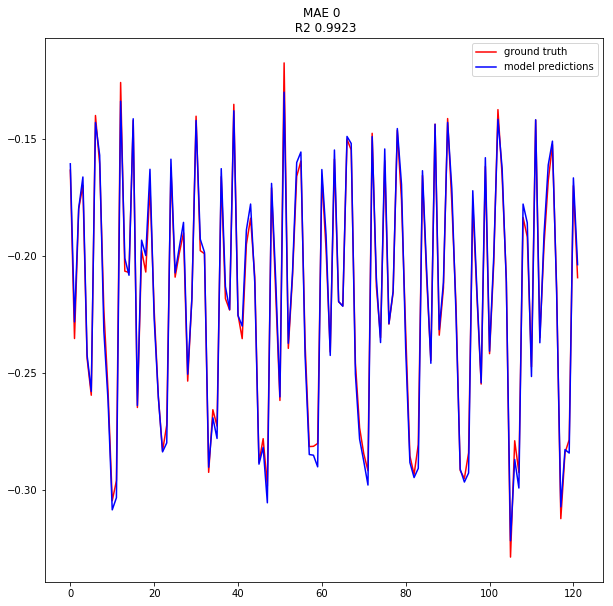

In [17]:
pred = model1.predict([past,fut,cur])
pred = np.array(pred).reshape((-1,))
test = y.reshape((-1,))

print(pred.shape, test.shape)

from sklearn.metrics import mean_absolute_error, r2_score
plt.figure(figsize=(10,10))
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test,pred), r2_score(test,pred)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()


In [18]:
pred = pred[test!=0]
test = test[test!=0]
print ('Mape: ',np.mean(np.abs(test-pred)/test))

Mape:  -0.017565575516


# Zuerich monthly sunspot

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 6, 256)       1536        input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 5, 256)       131328      conv1d_7[0][0]                   
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 5, 256)       65792       conv1d_8[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

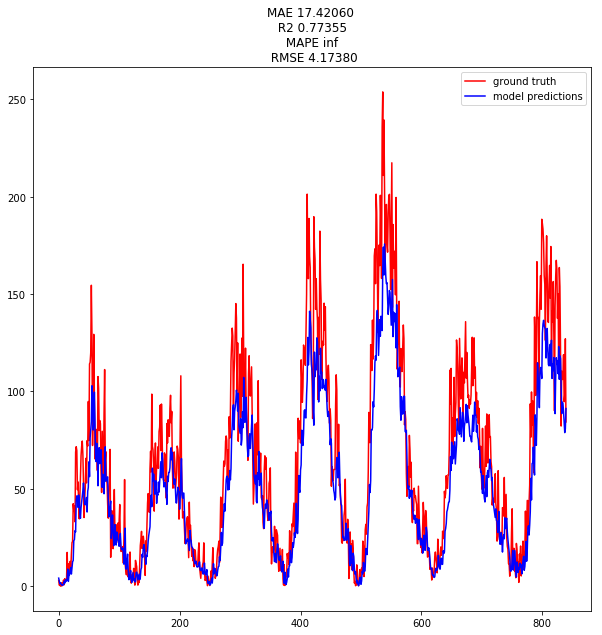

In [11]:
"""
    Without the multiplication of the cnn outputs.
    Both the multipliers , set to 0.
"""

data = pd.DataFrame(pd.read_csv("monthly-sunspot-number-zurich-17.csv"))
data = data[data.columns[1]]

time_steps = 21
num_features = 0
past,cur,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)

model1 = model_build1(past.shape[1:])
model1.fit(past_train, y_train, epochs=10, batch_size=32, validation_data=(past_test,y_test))

pred = model1.predict(past_test)
test = y_test.reshape((-1,1))

print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_184 (InputLayer)          (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_185 (InputLayer)          (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_245 (Conv1D)             (None, 6, 256)       1536        input_184[0][0]                  
__________________________________________________________________________________________________
conv1d_247 (Conv1D)             (None, 6, 256)       1536        input_185[0][0]                  
__________________________________________________________________________________________________
conv1d_246

Train on 1959 samples, validate on 840 samples
Epoch 1/10
1959/1959 [==============================] - 44s 23ms/step - loss: 21.1323 - mean_absolute_error: 21.6192 - val_loss: 13.2063 - val_mean_absolute_error: 13.6988
Epoch 2/10
1959/1959 [==============================] - 32s 16ms/step - loss: 13.2963 - mean_absolute_error: 13.7806 - val_loss: 13.3193 - val_mean_absolute_error: 13.8093
Epoch 3/10
1959/1959 [==============================] - 32s 16ms/step - loss: 12.7529 - mean_absolute_error: 13.2328 - val_loss: 18.2368 - val_mean_absolute_error: 18.7264
Epoch 4/10
1959/1959 [==============================] - 32s 16ms/step - loss: 13.2696 - mean_absolute_error: 13.7574 - val_loss: 13.2832 - val_mean_absolute_error: 13.7712
Epoch 5/10
1959/1959 [==============================] - 32s 16ms/step - loss: 12.0650 - mean_absolute_error: 12.5517 - val_loss: 25.6989 - val_mean_absolute_error: 26.1948
Epoch 6/10
1959/1959 [==============================] - 32s 16ms/step - loss: 12.1526 - mean_

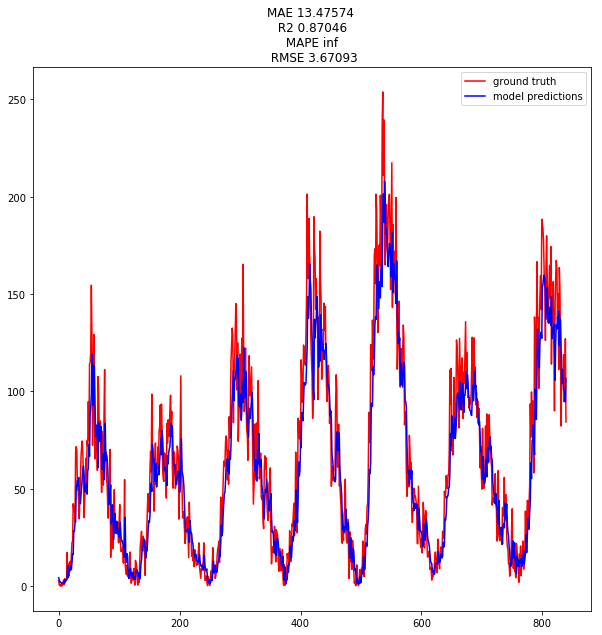

In [199]:
"""
    Both multiplier set to defuault values.
"""

data = pd.DataFrame(pd.read_csv("monthly-sunspot-number-zurich-17.csv"))
data = data[data.columns[1]]

time_steps = 21
num_features = 0
past,cur,fut,y = create_formatted_data(data, time_steps, num_features)
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)

model1 = model_build(past.shape[1:], fut.shape[1:], cur.shape[1:])
model1.fit([past_train, fut_train, cur_train], y_train, epochs=10, batch_size=32, validation_data=([past_test,fut_test,cur_test],y_test))

pred = model1.predict([past_test, fut_test, cur_test])
test = y_test.reshape((-1,1))

print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f \n RMSE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test), np.sqrt(mean_absolute_error(test,pred))))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

# Two Variants on the model training.

## Variant 1

## Variant 2

In [9]:
data = pd.DataFrame(pd.read_csv("../notNiteeshData.csv")['ES_POPCORN SMALL'])
print (data.shape)
data = data[data[data.columns[0]]!=0]
data = data[data[data.columns[0]]<=600]
data_train = data[:-100]
data_train.reset_index(drop=True,inplace=True)
data_test = data[-100:]
data_test.reset_index(drop=True,inplace=True)
print (data.shape,data_train.shape,data_test.shape)

(991, 1)
(899, 1) (799, 1) (100, 1)


In [ ]:
model1 = model_build(past.shape[1:], fut.shape[1:], cur.shape[1:])
model1.fit([past_train, fut_train, cur_train], y_train, epochs=100, batch_size=32, validation_data=([past_test,fut_test,cur_test],y_test))

In [ ]:
print(np.sqrt(mean_squared_error(test,pred)))

In [ ]:
#Build a Linear Regression for the predictions to Final Value.
#TRAINING THE LINEAR REGRESSOR.
linreg_data = pd.DataFrame(pred,columns=["Bi Pred"])
linreg_test = pd.DataFrame(test,columns=["Bi Test"])
print (linreg_data.shape , linreg_test.shape)
split = int(0.7*(linreg_data.shape[0]))

linreg_train_data = linreg_data.values[:split]
linreg_train_test = linreg_test.values[:split]

linreg_test_data = linreg_data.values[split+1:]
linreg_test_test = linreg_test.values[split+1:]

lin_model = linear_model.LinearRegression()
lin_model.fit(linreg_train_data,linreg_train_test)
lin_pred = lin_model.predict(linreg_test_data)

In [ ]:
print(lin_pred.shape, linreg_test_test.shape)
from sklearn.metrics import mean_absolute_error, r2_score
plt.figure(figsize=(10,10))
plt.title(" LINEAR REGRESSOR ")
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f"%(mean_absolute_error(linreg_test_test,lin_pred), r2_score(linreg_test_test,lin_pred), np.mean(np.abs(lin_test_test-lin_pred)/lin_test_test)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [ ]:
#Now, testing on the unseen part of the data, with this pipeline in place.
#Just the Bi- CNN LSTM DNN 's prediction.

pred = model1.predict([past_test,fut_test,cur_test])
pred = np.array(pred).reshape((-1,))
test = y_test.reshape((-1,))
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title(" Bi-CNN LSTM DNN TESTING !!")
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f"%(mean_absolute_error(test,pred), r2_score(test,pred), np.mean(np.abs(test-pred)/test)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()

In [ ]:
#Prediction augmented by the linear regressor.
lin_test_pred = lin_model.predict(pred)
print(pred.shape, test.shape)
plt.figure(figsize=(10,10))
plt.title(" Bi-CNN LSTM DNN followed by a LINEAR REGRESSOR TESTING !!")
plt.title("MAE %.5f \n R2 %.5f \n MAPE %.5f"%(mean_absolute_error(test,lin_test_pred), r2_score(test,lin_test_pred), np.mean(np.abs(test-lin_test_pred)/test)))
plt.plot(test, color='r', label='ground truth')
plt.plot(pred, color='b', label='model predictions')
plt.legend()
plt.show()